## Wavenet Properties

- [Link to wavenet repo for code used below](https://github.com/ibab/tensorflow-wavenet)

- Json file contains wavenet params, which are being displayed in output of cell below

In [1]:
import json

with open('wavenet_params.json', 'r') as f:
    wavenet_params = json.load(f)
    
for key in wavenet_params:
    print(key, ": ",wavenet_params[key])

filter_width :  2
sample_rate :  16000
dilations :  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
residual_channels :  32
dilation_channels :  32
quantization_channels :  256
skip_channels :  512
use_biases :  True
scalar_input :  False
initial_filter_width :  32


**The authors have stacked 5 blocks of \[1, 2, 4, 8, 16, 32, 64, 128, 256, 512\] dilations**

In [2]:
# from the code repository 

def calculate_receptive_field(filter_width, dilations, scalar_input, initial_filter_width):
    receptive_field = (filter_width - 1) * sum(dilations) + 1
    if scalar_input:
        receptive_field += initial_filter_width - 1
    else:
        receptive_field += filter_width - 1
    return receptive_field

In [3]:
receptive_field = calculate_receptive_field(wavenet_params["filter_width"],
                                                           wavenet_params["dilations"],
                                                           wavenet_params["scalar_input"],
                                                           wavenet_params["initial_filter_width"])
print("Receptive filed of all stacked dialtions included : " , receptive_field)

Receptive filed of all stacked dialtions included :  5117


In [4]:
print("Receptive field of a single block: ",calculate_receptive_field(wavenet_params["filter_width"],
                                [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
                                wavenet_params["scalar_input"],
                                wavenet_params["initial_filter_width"]))

Receptive field of a single block:  1025


**The paper says that the receptive field of \[1, 2, 4, 8, 16, 32, 64, 128, 256, 512\] block is 1024**

In [5]:
# simplified code (derived from repo)

import numpy as np
import tensorflow as tf
from wavenet import audio_reader

for audio, filename, category_id in audio_reader.load_generic_audio('./VCTK-Corpus', wavenet_params['sample_rate']):
    print (audio, filename, category_id)
    break # reading only one audio file
    
# load_generic_audio function uses librosa to load the audio 

files length: 44242
[[6.6434699e-03]
 [1.2343217e-02]
 [1.0841060e-02]
 ...
 [2.7900202e-05]
 [3.9438575e-05]
 [0.0000000e+00]] ./VCTK-Corpus/wav48/p256/p256_033.wav 256


In [6]:
import sounddevice as sd

# play audio before trimming the silence
fs = 16000
sd.play(audio, fs)

In [7]:
print("Audio shape before trimming silence: ", audio.shape)

Audio shape before trimming silence:  (79895, 1)


In [8]:
audio = audio_reader.trim_silence(audio[:, 0], 0.03)
print("Audio shape after trimming silence: ", audio.shape)
# trim_silence uses librosa to remove the silence
# return empty array if the whole audio was silence


# play audio after trimming the silence
sd.play(audio, fs)

Audio shape after trimming silence:  (25600,)


In [9]:
audio = audio.reshape(-1, 1) # reshaping to column vector
print(audio.shape) 

(25600, 1)


In [10]:
audio = np.pad(audio, [[receptive_field, 0], [0, 0]], 'constant')
# prepend zeros of size of receptive field 

print(audio.shape)

(30717, 1)


In [11]:
print(audio)

[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.02676006]
 [0.02716097]
 [0.02853504]]


In [12]:
# Set up session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
init = tf.global_variables_initializer()
sess.run(init)

In [13]:
sample_size = 100000 # from train.py

if sample_size:
    # Cut samples into pieces of size receptive_field +
    # sample_size with receptive_field overlap
    while len(audio) > receptive_field:
        piece = audio[:(receptive_field + sample_size), :]
        # sess.run(self.enqueue, feed_dict={self.sample_placeholder: piece})
        audio = audio[sample_size:, :]
        
# else:
#     sess.run(self.enqueue, feed_dict={self.sample_placeholder: piece})

## Parameters used in Tacotron-2 implementation

- [Link to tacotron repo for following code](https://github.com/Rayhane-mamah/Tacotron-2/)

- This implementation uses simplified wavenet as explained in Tacotron-2 paper
    - [Tacotron-2 uses 20 dilation layers](https://github.com/Rayhane-mamah/Tacotron-2/blob/432bbe1aff4276a1a31edd08472e29d3c07b8300/hparams.py#L200)
    - [2 stacks are used in Tacotron-2 (5 stacks are used in original Wavenet)](https://github.com/Rayhane-mamah/Tacotron-2/blob/432bbe1aff4276a1a31edd08472e29d3c07b8300/hparams.py#L201)

- [Hyperparameters are available in hparams.py of the repo](https://github.com/Rayhane-mamah/Tacotron-2/blob/master/hparams.py)

In [14]:
# simplified code (derived from repo)

layers = 20
stacks = 2
layers_per_stack = layers // stacks
print("Number of dilation layers per stack : ", layers_per_stack)

dilation_rate = []
for layer in range(layers):
        dilation_rate.append(2 ** (layer % layers_per_stack))

print("Dilations : ", dilation_rate)

Number of dilation layers per stack :  10
Dilations :  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]


In [15]:
#Mel spectrogram
n_fft = 2048, #Extra window size is filled with 0 paddings to match this parameter
hop_size = 275, #For 22050Hz, 275 ~= 12.5 ms (0.0125 * sample_rate)
win_size = 1100, #For 22050Hz, 1100 ~= 50 ms (If None, win_size = n_fft) (0.05 * sample_rate)
sample_rate = 22050, #22050 Hz (corresponding to ljspeech dataset) (sox --i <filename>)
frame_shift_ms = None, #Can replace hop_size parameter. (Recommended: 12.5)

---

# WaveNet Network architecture 

**Screenshots from TensorBoard**

![graph1.png](./images/graph1.png)

---
Expanded view of wavenet_1 and wavenet

---

![graph2.png](./images/graph2.png)

**As the name suggests dilated_stack name scope in both wavenet and wavenet_1 blocks have 50 dilation layers**
![graph3.png](./images/graph3.png)

## Extracting the weights

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
d = np.load("./weights.npz")  # load the saved weights

In [3]:
var_names = d.files  # get the names of variables

In [4]:
len(var_names) # only variable in the namespace 'wavenet' as restored while generated wav files 
# from 'wavenet' namespace there are 405 output tensors
print(var_names[:10]) # print first 10 variable names

['wavenet/causal_layer/filter', 'wavenet/dilated_stack/layer0/filter', 'wavenet/dilated_stack/layer0/gate', 'wavenet/dilated_stack/layer0/dense', 'wavenet/dilated_stack/layer0/skip', 'wavenet/dilated_stack/layer0/Variable', 'wavenet/dilated_stack/layer0/Variable_1', 'wavenet/dilated_stack/layer0/Variable_2', 'wavenet/dilated_stack/layer0/Variable_3', 'wavenet/dilated_stack/layer1/filter']


wavenet/causal_layer/filter (2, 256, 32)


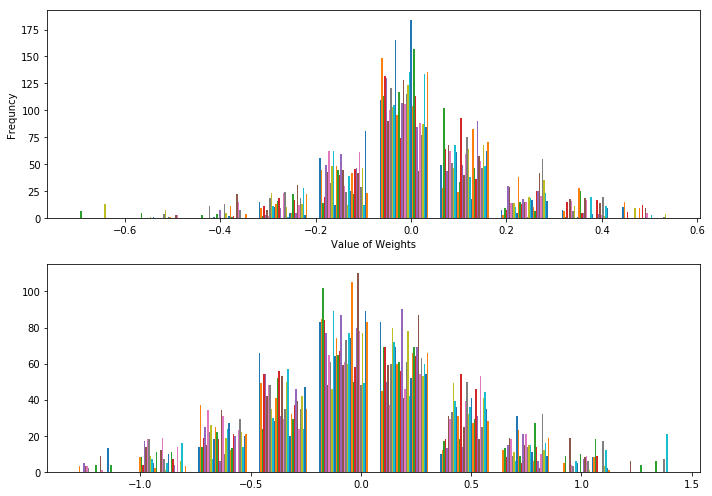

In [5]:
var1 = d[var_names[0]] # get the weights for first variable in causal layer in wavenet
print(var_names[0], var1.shape) # filter in causal layer has shape 2x256x32

# plot histogram
plt.figure(figsize=(10, 7))

plt.subplot(211)
plt.xlabel('Value of Weights')
plt.ylabel('Frequncy')
plt.hist(var1[0])

plt.subplot(212)
plt.hist(var1[1])

plt.tight_layout()

wavenet/dilated_stack/layer0/filter (2, 32, 32)


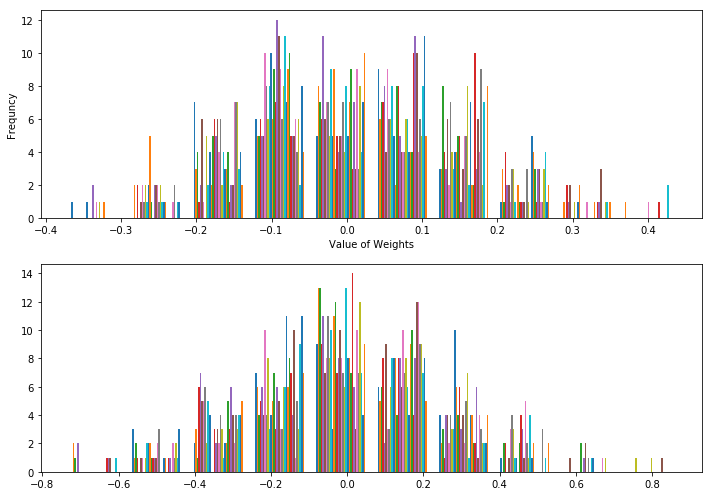

In [6]:
var2 = d[var_names[1]] # get the weights for first variable in causal layer in wavenet
print(var_names[1], var2.shape) # filter in causal layer has shape 2x256x32

# plot histogram
plt.figure(figsize=(10, 7))

plt.subplot(211)
plt.xlabel('Value of Weights')
plt.ylabel('Frequncy')
plt.hist(var2[0])

plt.subplot(212)
plt.hist(var2[1])

plt.tight_layout()

## Readind the npz and h5 files

In [7]:
class read_files:
    """Class to read npz and h5 files"""
    
    def get_file_names(self):
        """Returns two lists
        First list contains the file names for h5 files
        Second list contains the files names for npz files
        """
        names = np.loadtxt('file_names.txt', dtype='str')
        h5_file_names = ['./h5/'+name+'.h5' for name in names]
        npz_file_names = ['./npz/'+name+'.npz' for name in names]
        return h5_file_names, npz_file_names
        
    def read_h5_file(self, file_path):
        """
        Returns data read from the h5 file at 'file_path'
        """
        import h5py
        h5f = h5py.File(file_path, 'r')
        x = h5f[list(h5f.keys())[0]][:]
        h5f.close()
        return x
    
    def read_npz_file(self, file_path):
        """
        Returns data read from the npz file at 'file_path'
        """
        import numpy
        data = numpy.load(file_path)
        return data['arr_0'] # arr_0 is used as only one ndarray is saved per file

In [8]:
# files are stores as ./h5/wavenet/... and ./npz/wavenet/...
# ex: ./h5/wavenet/causal_layer/filter.h5 or ./npz/wavenet/causal_layer/filter.npz
# file names can be obtained from get_file_names() method in read_files class

rf = read_files() # create object of read_files class
h5_paths, npz_paths = rf.get_file_names() # call the get_file_names method to get the file names

# iterate through the file names and call the read_h5_file and read_npz_file methods
# to get the data from the files

for npz_path in npz_paths:
    print(rf.read_npz_file(npz_path))
    break # breaking only to display the data from first file
    
# similarly for the h5 files
for h5_path in h5_paths:
    print(rf.read_h5_file(h5_path))
    break # breaking only to display the data from first file

[[[ 0.13198492  0.44143334 -0.6503136  ...  0.3729906   0.4267268
   -0.40751252]
  [ 0.23740217  0.49362502 -0.5836682  ...  0.30807042  0.28862318
   -0.3121164 ]
  [ 0.27004355  0.3804924  -0.6907175  ...  0.40720135  0.2708221
   -0.30069882]
  ...
  [-0.18564308 -0.27960992  0.30621395 ...  0.07690006 -0.03034524
    0.00414981]
  [-0.17853643 -0.31269887  0.22084887 ...  0.27784044 -0.04692093
   -0.05483755]
  [-0.21037945 -0.32274288  0.24870642 ...  0.1797606   0.11793226
   -0.01017052]]

 [[-0.28731468 -0.38454184 -0.01629513 ...  0.38833877  0.05260267
   -0.70548093]
  [-0.2991783  -0.4305066  -0.04512043 ...  0.42956793 -0.06338572
   -0.5187924 ]
  [-0.17177151 -0.40136555 -0.1727786  ...  0.5342519   0.08970906
   -0.52208334]
  ...
  [-0.08396912 -0.00823107 -0.51682216 ...  0.7147563   0.25141755
   -0.39385006]
  [-0.0300974   0.02468077 -0.46505406 ...  0.71779674  0.2070059
   -0.32100356]
  [-0.02810353  0.08702274 -0.56245536 ...  0.8140703   0.47020254
   -0.403